# ViT Experimentation

In [1]:
# precocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime

sns.set()


# transformers
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from models.transformers.ViT import ViT

# optimze GPU training transformer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, logging

from tqdm.notebook import tqdm


# clear stuff for new training
torch.cuda.empty_cache()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# check GPUs
print(torch.cuda.device_count()) 

2


# Load & Preprocess Dataset

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])


# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Ankle Boot  Shirt  Ankle Boot  Ankle Boot


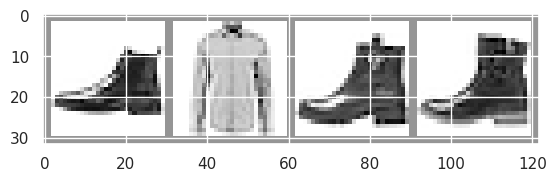

In [5]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

# Model Training

In [6]:
model = ViT(
    img_dim = 28,
    in_channels = 1,
    patch_dim = 7,
    num_classes = 10,
    dim = 128,
    blocks = 6,
    heads = 4
)

preds = model(images)
preds

tensor([[-0.0030, -0.3811, -1.0926,  0.0769,  0.5247, -0.2662, -1.8630,  0.4101,
         -1.1114, -0.1817],
        [ 0.1085, -0.1069, -1.2942, -0.2905,  0.8000, -0.3000, -1.6950,  0.5190,
         -1.1617, -0.0115],
        [-0.0755, -0.3450, -0.9888,  0.0296,  0.6679, -0.4211, -1.9156,  0.4732,
         -1.0959, -0.1724],
        [-0.1225, -0.3884, -1.0032,  0.0909,  0.7231, -0.4554, -1.8916,  0.5177,
         -1.0584, -0.1348]], grad_fn=<AddmmBackward0>)

In [7]:
# default_args = {
#     "output_dir": "tmp",
#     "evaluation_strategy": "steps",
#     "num_train_epochs": 1,
#     "log_level": "error",
#     "report_to": "none",
# }

# training_args = TrainingArguments(
#     per_device_train_batch_size=2,
#     gradient_accumulation_steps=4,
#     # gradient_checkpointing=True,
#     # gradient_checkpointing_kwargs={'use_reentrant': False}, # OR gradient_checkpointing_kwargs={'use_reentrant': True} 
#     fp16=True,
#     optim="adafactor",
#     **default_args,
# )

# trainer = Trainer(model=model, args=training_args, train_dataset=training_loader)
# result = trainer.train()

In [8]:
# declare loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)


def train_one_epoch(epoch_index, tb_writer):
    """
        Method to train the model for one epoch
    """
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    
    for i, data in tqdm(enumerate(training_loader)):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [9]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


0it [00:00, ?it/s]

  batch 1000 loss: 2.3250283232927322
  batch 2000 loss: 2.321318273663521
  batch 3000 loss: 2.3124047107696533
  batch 4000 loss: 2.3093707637786864
  batch 5000 loss: 2.3085897817611696
  batch 6000 loss: 2.3070538418293
  batch 7000 loss: 2.3061009356975557
  batch 8000 loss: 2.3056457369327545
  batch 9000 loss: 2.305497813940048
  batch 10000 loss: 2.3054392971992494
  batch 11000 loss: 2.310030135154724
  batch 12000 loss: 2.3064198808670042
  batch 13000 loss: 2.304207376718521
  batch 14000 loss: 2.305035269498825
  batch 15000 loss: 2.305972631692886
LOSS train 2.305972631692886 valid 2.3034262657165527
EPOCH 2:


0it [00:00, ?it/s]

  batch 1000 loss: 2.3038654549121858
  batch 2000 loss: 2.3041590135097505
  batch 3000 loss: 2.303297586917877
  batch 4000 loss: 2.304153476238251
  batch 5000 loss: 2.304084992647171
  batch 6000 loss: 2.3038296620845795
  batch 7000 loss: 2.304036317586899
  batch 8000 loss: 2.30367129445076
  batch 9000 loss: 2.305382108926773
  batch 10000 loss: 2.3014161772727966
  batch 11000 loss: 2.304193704366684
  batch 12000 loss: 2.3037464895248414
  batch 13000 loss: 2.3033749599456788
  batch 14000 loss: 2.303805455207825
  batch 15000 loss: 2.302869325399399
LOSS train 2.302869325399399 valid 2.303093671798706
EPOCH 3:


0it [00:00, ?it/s]

  batch 1000 loss: 2.3042801246643068
  batch 2000 loss: 2.303983803987503
  batch 3000 loss: 2.3039100987911225
  batch 4000 loss: 2.303520444393158
  batch 5000 loss: 2.3052617905139923
  batch 6000 loss: 2.3032281138896944
  batch 7000 loss: 2.3039685316085814
  batch 8000 loss: 2.304000138044357
  batch 9000 loss: 2.30405544090271
  batch 10000 loss: 2.301700190067291
  batch 11000 loss: 2.305323485374451
  batch 12000 loss: 2.269412987709045
  batch 13000 loss: 2.0960812802314757
  batch 14000 loss: 2.288062599778175
  batch 15000 loss: 2.22252143740654
LOSS train 2.22252143740654 valid 2.138338804244995
EPOCH 4:


0it [00:00, ?it/s]

  batch 1000 loss: 2.1333376874923706
  batch 2000 loss: 2.168718023657799
  batch 3000 loss: 2.3066401460170747
  batch 4000 loss: 2.2645553328990937
  batch 5000 loss: 2.1945915108919145
  batch 6000 loss: 2.2044270955324174
  batch 7000 loss: 2.2296674674749375
  batch 8000 loss: 2.2271815320253374
  batch 9000 loss: 2.216576427459717
  batch 10000 loss: 2.2102787631750105
  batch 11000 loss: 2.216744926214218
  batch 12000 loss: 2.135100646495819
  batch 13000 loss: 2.1109414993524553
  batch 14000 loss: 2.118752495884895
  batch 15000 loss: 2.1143407677412034
LOSS train 2.1143407677412034 valid 2.1189098358154297
EPOCH 5:


0it [00:00, ?it/s]

  batch 1000 loss: 2.122529414772987
  batch 2000 loss: 2.1234034526348116
  batch 3000 loss: 2.2918696714639664
  batch 4000 loss: 2.21900528049469
  batch 5000 loss: 2.1122775714397433
  batch 6000 loss: 2.100353215098381
  batch 7000 loss: 2.102204479455948
  batch 8000 loss: 2.0831536659002303
  batch 9000 loss: 2.1147386119365694
  batch 10000 loss: 2.091181355714798
  batch 11000 loss: 2.1593007415533068
  batch 12000 loss: 2.159592225790024
  batch 13000 loss: 2.1584338837862016
  batch 14000 loss: 2.1343843717575073
  batch 15000 loss: 2.229375657439232
LOSS train 2.229375657439232 valid 2.325929880142212


In [13]:
# save the moedl
PATH = './models/outputs/vitnet.pth'

In [11]:
torch.save(model.state_dict(), PATH)

# Validation Against Ground Truthe

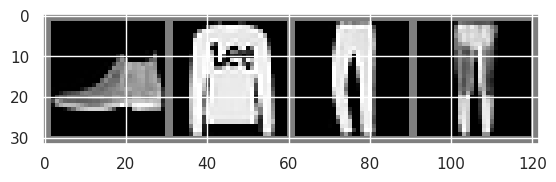

GroundTruth:  Ankle Boot Pullover Trouser Trouser


In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(validation_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [15]:
net = ViT(
    img_dim = 28,
    in_channels = 1,
    patch_dim = 7,
    num_classes = 10,
    dim = 128,
    blocks = 6,
    heads = 4
)

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Bag   Bag   Bag   Bag  
